In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from scipy.stats import boxcox

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

In [2]:
class BaseConverter:
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, x):
        out = np.array(x, dtype=str)
        if out.ndim > 1:
            return out
        return out.reshape(-1,1)

    def get_params(self, **kwargs):
        return self.__dict__
    
    def set_params(self, d, **kwargs):
        for k, v in d.items():
            setattr(self, k, v)

In [3]:
class NameConverter(BaseConverter):
    def __init__(self, use_class=False):
        self.use_class = use_class

    def transform(self, names):
        out = names.astype(str)
        out = self.get_title(out)
        if self.use_class:
            out = self.get_class(out)
        return out

    def get_title(self, names):
        out = []
        for name, in names:
            ttl = name.split(', ')[1].removeprefix('the ').split()[0]
            out += [[ttl]]
        return np.array(out)

    def get_class(self, titles):
        classes = dict(
            normal = ['Mr.', 'Mrs.', 'Ms.', 'Miss.', 'Master.', 'Mlle.', 'Mme.'],
            service = ['Dr.', 'Rev.', 'Major.', 'Col.', 'Capt.'],
            aristocrat = ['Countess.', 'Lady.', 'Sir.', 'Don.', 'Dona.', 'Jonkheer.'],
            )
        out = []
        for ttl in titles[:]:
            for k, v in classes.items():
                if ttl in v:
                    out += [[k]]
                    break
        return np.array(out)

In [4]:
class TicketConverter(BaseConverter):
    def transform(self, tickets):
        out = []
        for ticket, in tickets:
            s = ticket.split()
            if len(s) == 1:
                out += [['nan']]
            else:
                out += [s[:1]]
        return np.array(out)

In [5]:
class CabinConverter(BaseConverter):
    def __init__(self, cabin_tag_encoder=None):
        self.cabin_tag_encoder = cabin_tag_encoder
        
    def fit(self, cabins, *args):
        out = self.split_cabins(cabins)
        if self.cabin_tag_encoder is not None:
            self.cabin_tag_encoder.fit(out[:,1].reshape(-1,1), *args)
        return self
        
    def transform(self, cabins):
        out = self.split_cabins(cabins)
        if self.cabin_tag_encoder is not None:
            num = out[:,0]
            tag = self.cabin_tag_encoder.transform(out[:,1].reshape(-1,1))
            out = np.array([num, tag.flatten()], dtype=int).T
        return out
        
    def split_cabins(self, cabins):
        """ extract cabin tag and number of cabins from cabin """
        out = []
        for cabin, in cabins.astype(str):
            tag, num = 'nan', 0
            if cabin != 'nan':
                s = cabin.split()
                tag, num = s[0][0], len(s)
            if self.cabin_tag_encoder is not None:
                out += [[num, tag]]
            else:
                out += [[num]]
        return np.array(out)

In [6]:
class CategoricalConverter(Pipeline):
    def __init__(self, converter=None):
        self.converter = converter
        if converter is None:
            self.converter = BaseConverter()
        super().__init__([
            ('conv', converter),
            ('enc', OrdinalEncoder()),
            ])

In [7]:
class NumericConverter(BaseConverter):
    
    def fit(self, x, y=None):
        x_, self.lmbda_ = boxcox(x.flatten())
        return self
    
    def transform(self, x):
        out = np.zeros_like(x)
        return boxcox(x.flatten(), lmbda=self.lmbda_)

In [29]:
class CustomColTrans(ColumnTransformer):
    def __init__(self,
                 use_class=False, cabin_tag_encoder=None,
                 input_names=None, names_to_drop=None):
        self.use_class = use_class
        self.cabin_tag_encoder = cabin_tag_encoder
        self.names_to_drop = names_to_drop
        assert input_names is not None
        self.input_names = input_names
        cvtrs = dict(
            name=CategoricalConverter(converter=NameConverter(use_class=use_class)),
            ticket=CategoricalConverter(converter=TicketConverter()),
            cabin=CabinConverter(cabin_tag_encoder=cabin_tag_encoder),
            vcat=CategoricalConverter(converter=BaseConverter()),
            vint='passthrough',
            vfloat=StandardScaler(),
#             vfloat=MinMaxScaler(),
#             vfloat=NumericConverter(),
            )
        if names_to_drop is None:
            names_to_drop = []
        transformers = []
        for n, cols in self.column_map.items():
            icols = [self.input_names.index(x) for x in cols
                    if x not in names_to_drop]
            if len(icols)>0:
                transformers += [(n, cvtrs[n], icols)]
        super().__init__(transformers, remainder='drop')

    @property
    def column_map(self):
        return dict(
            name=['Name'],
            cabin=['Cabin'],
            ticket=['Ticket'],
            vcat=['Sex', 'Embarked'],
            vint=['Pclass', 'SibSp', 'Parch'],
            vfloat=['Age', 'Fare'],
            )
        
    @property
    def columns(self):
        '''
        '''
        name_maps = dict(
            Name=['Class'] if self.use_class else ['Title'],
            Cabin=['NumCabins', 'CabinTag'],
            Ticket=['TicketTag'],
            )
        cmap = self.column_map
        if self.cabin_tag_encoder is None:
            name_maps['Cabin'].remove('CabinTag')
        names = []
        for _, _, icols in self.transformers:
            for i in icols:
                n = self.input_names[i]
                names += name_maps.get(n, [n])
        return names

In [9]:
def proc_data(df):
    y = df.Survived
    df_ = df.drop('Survived', axis=1)
    x = df_.values
    input_names = list(df_.columns)
    return x, y, input_names

In [10]:
def fit_and_check_importance(pipeline, x, y):
    pipeline.fit(x, y, classifier__eval_metric='logloss')
    feature_names = np.array(pipeline.named_steps['preproc'].columns)
    importances = pipeline.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)
    # std = np.std([tree.feature_importances_ for tree in forest.estimators_],
    #              axis=0)
    n_ft = len(importances)

    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(n_ft), importances[indices],
             color="r",
             #xerr=std[indices],
             align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(n_ft), feature_names[indices])
    plt.ylim([-1, n_ft])
    plt.show()
    return pipeline

In [109]:
def training_curves(preproc, model, x_train, y_train, x_val, y_val, **kwargs):
    preproc.fit(x_train, y_train)
    xt = preproc.transform(x_train)
    xv = preproc.transform(x_val)
    eval_set = [(xt, y_train), (xv, y_val)]
    metrics = ["error", "logloss"]
    model.fit(xt, y_train,
                  eval_metric=metrics,
                  eval_set=eval_set,
                  **kwargs)
    # make predictions for test data
    y_pred = model.predict(xv)
    # evaluate predictions
    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    # retrieve performance metrics
    results = model.evals_result()
    for m in ['logloss']:
        epochs = len(results['validation_0'][m])
        x_axis = range(0, epochs)
        # plot log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0'][m], label='Train')
        ax.plot(x_axis, results['validation_1'][m], label='Test')
        ax.legend()
        plt.ylabel(m)
        plt.title(f'XGBoost {m}')
        plt.show()
        return

In [33]:
df = pd.read_csv('train.csv', index_col='PassengerId')
x, y, input_names = proc_data(df)
x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=7, test_size=.33)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [34]:
ct = CustomColTrans(use_class=True, cabin_tag_encoder=OrdinalEncoder(),
                   input_names=input_names)
ct.fit(x, y)
dft = pd.DataFrame(
    data=ct.transform(x),
    index=df.index,
    columns=ct.columns,
    )
dft

,Class,NumCabins,CabinTag,TicketTag,Sex,Embarked,Pclass,SibSp,Parch,Age,Fare
PassengerId,,,,,,,,,,,
1,1.0,0,8,4.0,1.0,2.0,3,1,0,-0.530377,-0.502445
2,1.0,1,2,17.0,0.0,0.0,1,1,0,0.571831,0.786845
3,1.0,0,8,36.0,0.0,2.0,3,0,0,-0.254825,-0.488854
4,1.0,1,2,42.0,0.0,2.0,1,1,0,0.365167,0.420730
5,1.0,0,8,42.0,1.0,2.0,3,0,0,0.365167,-0.486337
...,...,...,...,...,...,...,...,...,...,...,...
887,2.0,0,8,42.0,1.0,2.0,2,0,0,-0.185937,-0.386671
888,1.0,1,1,42.0,0.0,2.0,1,0,0,-0.737041,-0.044381
889,1.0,0,8,38.0,0.0,2.0,3,1,2,NaN,-0.176263


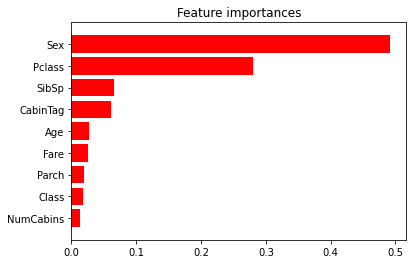

Pipeline(steps=[('preproc',
                 CustomColTrans(cabin_tag_encoder=OrdinalEncoder(),
                                input_names=['Pclass', 'Name', 'Sex', 'Age',
                                             'SibSp', 'Parch', 'Ticket', 'Fare',
                                             'Cabin', 'Embarked'],
                                names_to_drop=['Ticket', 'Embarked'],
                                use_class=True)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, g...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n

In [35]:
ct_params=dict(
    use_class=True,
    cabin_tag_encoder=OrdinalEncoder(),
    input_names=input_names,
    names_to_drop=['Ticket', 'Embarked'],
    )
xgb_params = dict(
    objective='binary:logistic',
    use_label_encoder=False,
    max_depth=3,
    reg_alpha=.5,
#     learning_rate=.001,
#     n_estimators=2000,
    )
pipeline = Pipeline([
    ('preproc', CustomColTrans(**ct_params)),
    ('classifier', XGBClassifier(**xgb_params)),
    ])
fit_and_check_importance(pipeline, x, y)

Accuracy: 78.98%


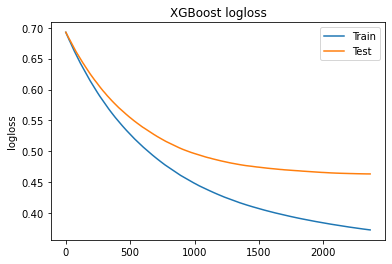

In [117]:
ct_params=dict(
    use_class=True,
    cabin_tag_encoder=OrdinalEncoder(),
    input_names=input_names,
    names_to_drop=['Ticket', 'Embarked', 'Name', 'Parch'],
    )
preproc = CustomColTrans(**ct_params)
xgb_params = dict(
    objective='binary:logistic',
    use_label_encoder=False,
    max_depth=3,
    reg_alpha=.5,
    colsample_bylevel = .8,
    learning_rate=.001,
    n_estimators=4000,
    )
model = XGBClassifier(**xgb_params)
pipeline = Pipeline([
    ('preproc', preproc),
    ('classifier', model),
    ])
if 0:
    pipeline.fit(x, y, classifier__eval_metric='logloss')
elif 0:
    pipeline = fit_and_check_importance(pipeline, x_train, y_train)
    y_pred = pipeline.predict(x_val)
    accuracy_score(y_val, y_pred)
else:
    training_curves(preproc, model, x_train, y_train, x_val, y_val,
                   verbose=False,
                   early_stopping_rounds=20,
                   )

Accuracy: 79.66%


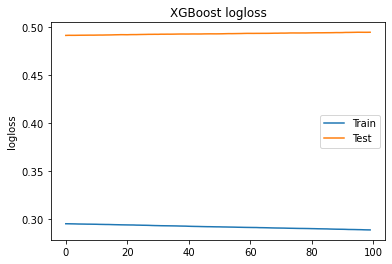

In [99]:
# continue training?
training_curves(preproc, model, x_train, y_train, x_val, y_val,
               xgb_model=model.get_booster(), verbose=False)

Accuracy: 78.64%


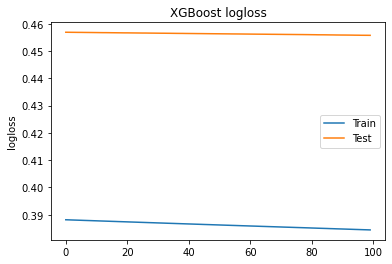

In [88]:
# continue training?
training_curves(preproc, model, x_train, y_train, x_val, y_val,
               xgb_model=model.get_booster(), verbose=False)

In [86]:
ct = pipeline.named_steps['preproc']
ct.transformers, ct.columns, ct.input_names

([('cabin', <__main__.CabinConverter at 0x7f6c373d3d30>, [8]),
  ('vcat',
   CategoricalConverter(converter=<__main__.BaseConverter object at 0x7f6c373d3250>),
   [2]),
  ('vint', 'passthrough', [0, 4]),
  ('vfloat', StandardScaler(), [3, 7])],
 ['NumCabins', 'CabinTag', 'Sex', 'Pclass', 'SibSp', 'Age', 'Fare'],
 ['Pclass',
  'Name',
  'Sex',
  'Age',
  'SibSp',
  'Parch',
  'Ticket',
  'Fare',
  'Cabin',
  'Embarked'])

[0]	validation_0-logloss:0.55753	validation_0-error:0.14765	validation_1-logloss:0.57553	validation_1-error:0.21356
[1]	validation_0-logloss:0.48325	validation_0-error:0.14765	validation_1-logloss:0.51600	validation_1-error:0.21356
[2]	validation_0-logloss:0.43892	validation_0-error:0.14765	validation_1-logloss:0.48320	validation_1-error:0.21356
[3]	validation_0-logloss:0.41115	validation_0-error:0.14765	validation_1-logloss:0.46704	validation_1-error:0.21356
[4]	validation_0-logloss:0.39343	validation_0-error:0.14765	validation_1-logloss:0.45886	validation_1-error:0.21356
[5]	validation_0-logloss:0.38108	validation_0-error:0.14765	validation_1-logloss:0.45804	validation_1-error:0.21356
[6]	validation_0-logloss:0.37122	validation_0-error:0.14765	validation_1-logloss:0.45583	validation_1-error:0.21356
[7]	validation_0-logloss:0.36336	validation_0-error:0.14430	validation_1-logloss:0.45603	validation_1-error:0.20678
[8]	validation_0-logloss:0.35658	validation_0-error:0.14430	validation_1

[71]	validation_0-logloss:0.23757	validation_0-error:0.08893	validation_1-logloss:0.52442	validation_1-error:0.20678
[72]	validation_0-logloss:0.23669	validation_0-error:0.08893	validation_1-logloss:0.52595	validation_1-error:0.20678
[73]	validation_0-logloss:0.23575	validation_0-error:0.08893	validation_1-logloss:0.52635	validation_1-error:0.20678
[74]	validation_0-logloss:0.23505	validation_0-error:0.08893	validation_1-logloss:0.52564	validation_1-error:0.20339
[75]	validation_0-logloss:0.23376	validation_0-error:0.08725	validation_1-logloss:0.52492	validation_1-error:0.20000
[76]	validation_0-logloss:0.23319	validation_0-error:0.08893	validation_1-logloss:0.52643	validation_1-error:0.20339
[77]	validation_0-logloss:0.23242	validation_0-error:0.08893	validation_1-logloss:0.52807	validation_1-error:0.20339
[78]	validation_0-logloss:0.23184	validation_0-error:0.08893	validation_1-logloss:0.52825	validation_1-error:0.20339
[79]	validation_0-logloss:0.23161	validation_0-error:0.08893	val

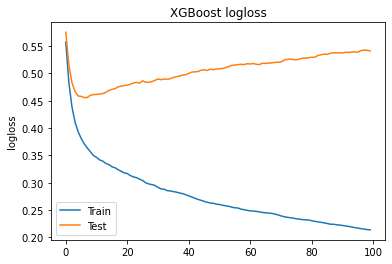

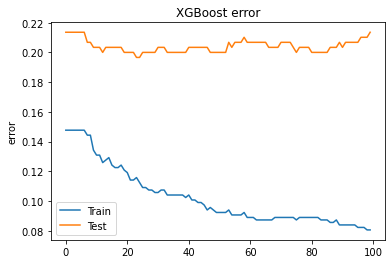

In [48]:
training_curves(preproc, model, x_train, y_train, x_val, y_val)

In [55]:
model.fit?
